In [1]:
%load_ext autoreload
#always reload modules so that as you change code, it gets loaded
%autoreload 2
#%aimport rl # make sure you call once: pip install -e . 


import numpy as np
import matplotlib.pyplot as plt

from rl.simulations import parallel as para
from rl.bandits import simulations_decorators
from rl.bandits import k_arms_reward_creator
from rl.bandits import greedy_ee, greedy_ucb 
np.random.seed(42)

In [2]:
arms = 10
q_stars, bandits = k_arms_reward_creator(k=arms)

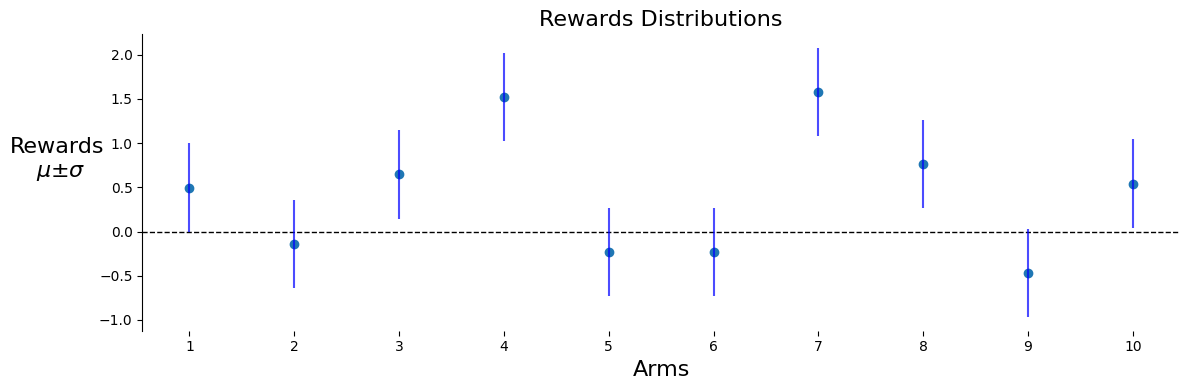

In [53]:
ig, ax1 = plt.subplots(1,1,figsize=(12,4))
ax1.scatter(range(1,arms+1), q_stars)

ax1.axhline(0, color='black', lw=1, linestyle='--')
for i in range(arms):
   ax1.vlines(x=i+1,
              ymin=q_stars[i]-.5,
              ymax=q_stars[i]+.5,
              alpha=.7,
              color='blue') 
ax1.set_xlabel("Arms", fontsize=16)
ax1.set_xticks(range(1, arms+1))
ax1.set_ylabel("Rewards\n $\mu±\sigma$", fontsize=16, rotation=0)
ax1.yaxis.labelpad = 30
ax1.spines.top.set_visible(False)
ax1.spines.right.set_visible(False)
ax1.spines.bottom.set_visible(False)
plt.title("Rewards Distributions", fontsize=16)
plt.tight_layout()
plt.show()

In [65]:
Qs, stats = greedy_ee(arms, bandits, epsilon=0.1, max_try=10000)
print('q_stars:\t',q_stars)
print('Estimated Qs:\t',Qs)
print('rewards:', np.sum(stats['rewards']))
print('Ns:', stats['Ns'])
print('Actions:', stats['actions'])

q_stars:	 [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
Estimated Qs:	 [ 0.59570038 -0.09835411  0.61409914  1.52948817 -0.16501676 -0.16603681
  1.56304646  0.5324638  -0.42033457  0.57498298]
rewards: 14325.16923695121
Ns: [  92.  102.  143. 4552.   90.  105. 4602.  107.  107.  100.]
Actions: [0. 0. 0. ... 6. 6. 6.]


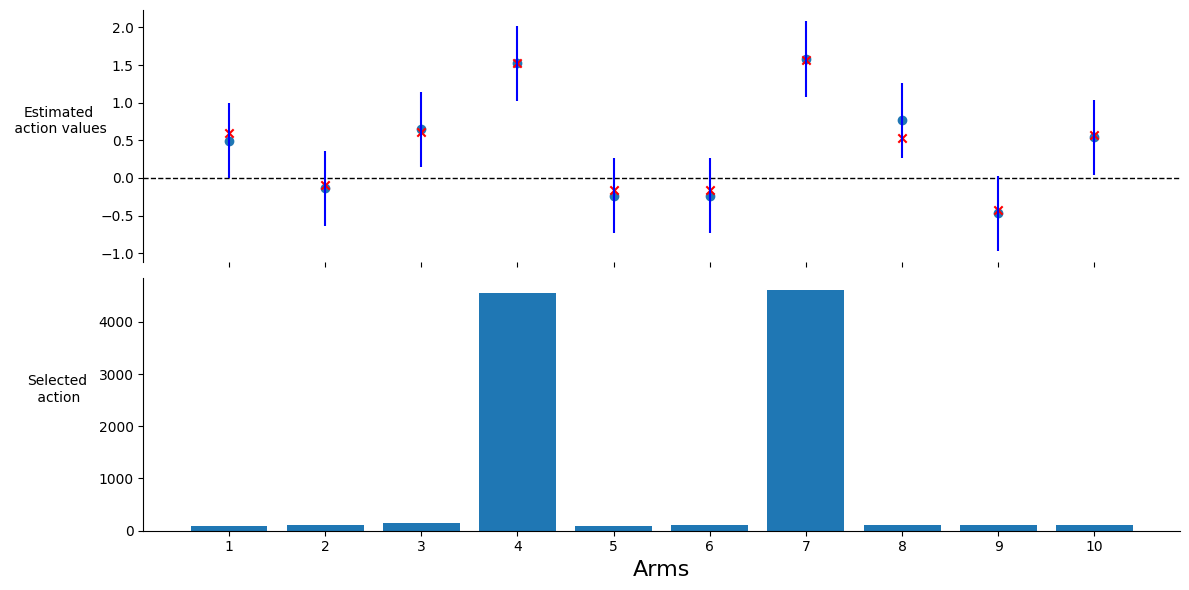

In [74]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,6), sharex=True)
arms_list = range(1,arms+1)
ax1.scatter(arms_list, q_stars)
ax1.axhline(0, color='black', lw=1, linestyle='--')
for i in range(arms):
   ax1.vlines(x=i+1, ymin=q_stars[i]-.5, ymax=q_stars[i]+.5, color='blue') 

ax1.scatter(arms_list, Qs, color='red', marker='x')
ax1.spines[['right', 'top', 'bottom']].set_visible(False)
ax1.set_xticks(arms_list)
ax1.set_ylabel("Estimated\n action values", rotation=0)
ax1.yaxis.labelpad = 30

ax2.bar(arms_list,stats['Ns'])
ax2.set_xticks(arms_list)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_xlabel("Arms", fontsize=16)
ax2.set_ylabel("Selected\n action", rotation=0)
ax2.yaxis.labelpad = 30
plt.tight_layout();plt.show()

# Comparing greedy search vs exploration/exploitation

In [6]:
rewards_per_epsilon = []
actions_per_epsilon = []
epsilons = [0, 0.01, .1]
simulation_steps_length = 1000
para_2 = simulations_decorators(para)

for epsilon in epsilons:
    Qs, stats = para_2(greedy_ee,
                      simulations = 2000,
                      concurrent = 25,
                      func_uniqe_index = False,
                      func_args = (arms, bandits, epsilon, simulation_steps_length))
              
    rewards_per_epsilon.append(stats['rewards'])
    actions_per_epsilon.append(stats['actions'])

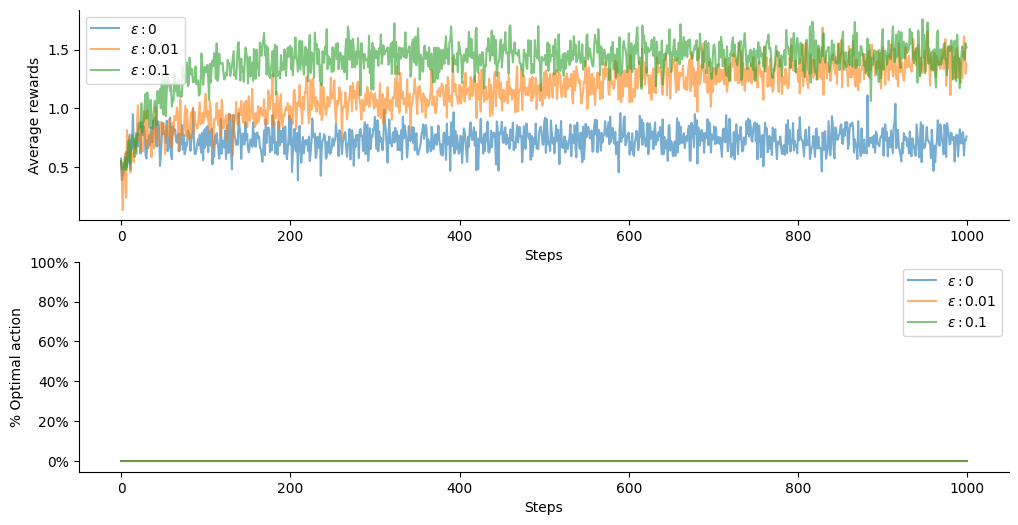

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,6))
for rewards, epsilon in zip(rewards_per_epsilon, epsilons):
    ax1.plot(rewards.mean(axis=0), label=f"$\epsilon:${epsilon}", alpha=.6)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Average rewards')
ax1.spines[['right', 'top']].set_visible(False)
ax1.legend()

optimal_action = np.argmax(q_stars)
for actions, epsilon in zip(rewards_per_epsilon, epsilons):
    ax2.plot((actions == optimal_action).mean(axis=0), 
             label=f"$\epsilon:${epsilon}", alpha=.6)
ax2.set_xlabel('Steps')
ax2.set_ylabel('% Optimal action')
ax2.set_yticks(np.arange(0, 1.1, .2))
ax2.set_yticklabels([str(int(i))+"%" for i in np.arange(0, 110, 20)])
ax2.spines[['right', 'top']].set_visible(False)

ax2.legend()
plt.show()

# Optimistic Initial Values

In [8]:
actions_per_epsilon = []
epsilons = [0, .1]
init_Qs = [5, 0]
simulation_steps_length = 1000
para_2 = simulations_decorators(para)

for epsilon, init_Q in zip(epsilons, init_Qs):
    Qs, stats = para_2(greedy_ee,
                      simulations = 2000,
                      concurrent = 25,
                      func_uniqe_index = False,
                      func_args = (arms, bandits, epsilon, simulation_steps_length, init_Q))
              
    actions_per_epsilon.append(stats['actions'])

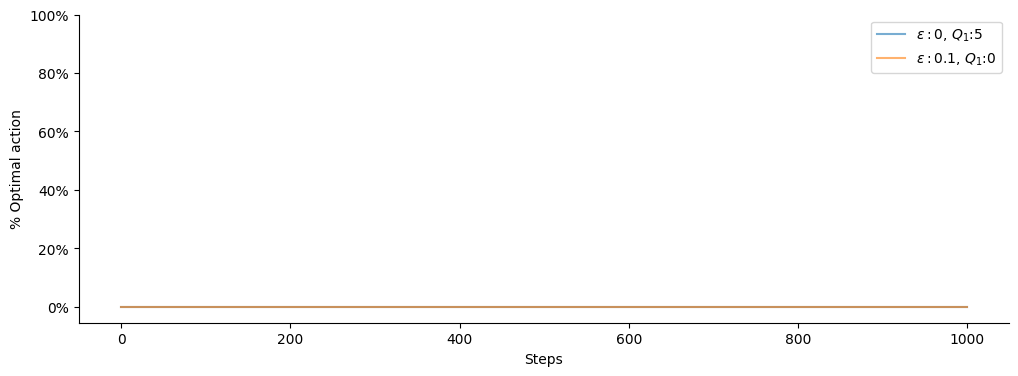

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
optimal_action = np.argmax(q_stars)
for actions, epsilon, init_Q in zip(rewards_per_epsilon, epsilons, init_Qs):
    ax.plot((actions == optimal_action).mean(axis=0), 
             label=f"$\epsilon:${epsilon}, $Q_1$:{init_Q}", alpha=.6)
ax.set_xlabel('Steps')
ax.set_ylabel('% Optimal action')
ax.set_yticks(np.arange(0, 1.1, .2))
ax.set_yticklabels([str(int(i))+"%" for i in np.arange(0, 110, 20)])
ax.spines[['right', 'top']].set_visible(False)

ax.legend()
plt.show()

# Upper-Confidence-Bound

In [10]:
rewards_per_epsilon = []

simulation_steps_length = 1000
para_2 = simulations_decorators(para)
epsilon=0.1
c = 2.0

Qs, stats = para_2(greedy_ee,
                    simulations = 2000,
                    concurrent = 25,
                    func_uniqe_index = False,
                    func_args = (arms, bandits, epsilon, simulation_steps_length, init_Q))
            
rewards_per_epsilon.append(stats['rewards'])

Qs, stats = para_2(greedy_ucb,
                    simulations = 2000,
                    concurrent = 25,
                    func_uniqe_index = False,
                    func_args = (arms, bandits, c, simulation_steps_length, init_Q))
            
rewards_per_epsilon.append(stats['rewards'])

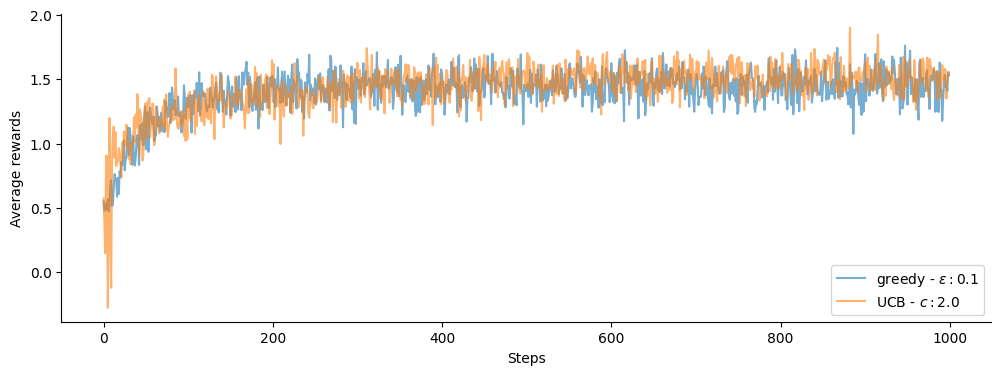

In [11]:
fig, ax1 = plt.subplots(1,1,figsize=(12,4))

ax1.plot(rewards_per_epsilon[0].mean(axis=0), 
         label=f"greedy - $\epsilon:${epsilon}", alpha=.6)
ax1.plot(rewards_per_epsilon[1].mean(axis=0), 
         label=f"UCB - $c:${c}", alpha=.6)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Average rewards')
ax1.spines[['right', 'top']].set_visible(False)
ax1.legend()


ax1.legend()
plt.show()

# Gradient Bandit Algorithm